# Process
In this notebook, I will analyse the results of the recommendation.

## A. Import Libraries

In [1]:
import warnings
import pickle as pkl
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
#from run_algorithms import train_algorithms, train_algorithms_kf, prepare_dataset, prepare_dataset_kf
from tqdm import tqdm
import time
pd.set_option("display.precision", 6)
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, NMF
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR
from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


## B. Set Hyperparameters

In [2]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "book" # the item column
my_seed = 0 # random_seed
top_fraction_items = 0.2 # the limit for an item to be considered popular
top_fraction_users = 0.2# the limit for a user to be considered High Mainstriminess
split_by = "pop_fraq" # sort users by fraction of popular items (pop_fraq) or by average popularity in profile (pop_item_fraq)
rd.seed(my_seed)
np.random.seed(my_seed)

These additions will be useful so we can load and save the different files (plots and processed data) with clarity on the hyperparameters.

In [3]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_by=="pop_fraq") else "_sbpif")

## C. Read Files
Files to read:
1. df_item_dist: the popularity of every item both in profiles and in recommendations (For Surprise and Cornac)
2. exp_results & exp_metrics: the Cornac results & metrics
3. low_rec_gap_list etc: the GAP in recommendations for all algorithms per group (for Surprise and Cornac)
4. GAP_list: the GAP in profile per group
5. training_ids: the user training ids
6. low, med, high: the low, med and high users

In [6]:
raw_file_location = "data/raw/" # here are stored the raw data files
processed_file_location = "data/processed/" # here we store the processed data files

In [7]:
df_item_dist_Cornac = pd.read_csv(processed_file_location+recommendation_type+"/item_pop_dist"+addition_1+"_results_Cornac10_new.csv", index_col=0)
#df_item_dist_Surprise = pd.read_csv(processed_file_location+recommendation_type+"/item_pop_dist"+addition_1+"_results_Surprise.csv", index_col=0)

In [8]:
df_item_dist_Cornac.head()

,count,Random,MostPop,UserKNN,MF,PMF,BPR,NMF,WMF,PF,NeuMF,VAECF
121,0.059018,12,6350,3710,96,62,6350,0,667,946,6350,3061
68,0.043595,15,6350,2024,274,291,6350,0,860,751,6350,1975
40,0.039817,19,6350,1980,14,18,6350,0,458,1057,6350,2112
413,0.039031,17,6350,1335,197,180,6350,1,694,782,6350,1496
443,0.037299,13,6350,2184,156,24,6350,0,474,1093,6350,1833


In [9]:
#df_item_dist_Surprise.head()

In [10]:
# Cornac results
with open(processed_file_location+recommendation_type+"/experiment_results_cornac"+addition_4+"10_new.pkl", "rb") as f:
    exp_results = pkl.load(f)
with open(processed_file_location+recommendation_type+"/experiment_metrics_cornac"+addition_4+"10_new.pkl", "rb") as f:
    exp_metrics = pkl.load(f)

In [11]:
# Lists for low,med,high, for both Surprise and Cornac
with open(processed_file_location+recommendation_type+"/low_rec_gap_list_cornac"+addition_4+"10_new.pkl", "rb") as f:
    low_rec_gap_list_Cornac = pkl.load(f)
with open(processed_file_location+recommendation_type+"/med_rec_gap_list_cornac"+addition_4+"10_new.pkl", "rb") as f:
    med_rec_gap_list_Cornac = pkl.load(f)
with open(processed_file_location+recommendation_type+"/high_rec_gap_list_cornac"+addition_4+"10_new.pkl", "rb") as f:
    high_rec_gap_list_Cornac = pkl.load(f)
    
# with open(processed_file_location+recommendation_type+"/low_rec_gap_list_Surprise"+addition_4+".pkl", "rb") as f:
#     low_rec_gap_list_Surprise = pkl.load(f)
# with open(processed_file_location+recommendation_type+"/med_rec_gap_list_Surprise"+addition_4+".pkl", "rb") as f:
#     med_rec_gap_list_Surprise = pkl.load(f)
# with open(processed_file_location+recommendation_type+"/high_rec_gap_list_Surprise"+addition_4+".pkl", "rb") as f:
#     high_rec_gap_list_Surprise = pkl.load(f)

In [12]:
with open(processed_file_location+recommendation_type+"/GAP_list"+addition_4+"_new.pkl", "rb") as f:
    GAP_list = pkl.load(f)
low_GAP = GAP_list[0]
med_GAP = GAP_list[1]
high_GAP = GAP_list[2]

In [13]:
with open(processed_file_location+recommendation_type+"/training_user_ids"+addition_4+"_cornac10_new.pkl", "rb") as f:
    training_ids = pkl.load(f)

In [14]:
with open(processed_file_location+recommendation_type+"/low_users"+addition_4+"_new.csv", "rb") as f:
    low_users = pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/med_users"+addition_4+"_new.csv", "rb") as f:
    med_users =  pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/high_users"+addition_4+"_new.csv", "rb") as f:
    high_users =  pd.read_csv(f,  index_col=0)

## D. Analyze Results

In [15]:
algo_names = ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']

### D.2. Profile Gender ratio vs Recommendation Gender Ratio

### D.1. Profile Popularity vs Recommendation Popularity

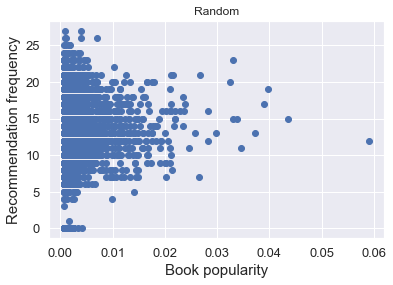

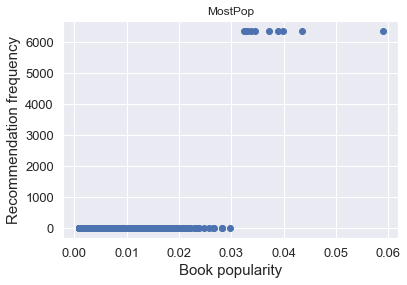

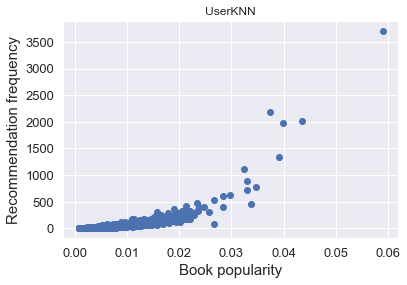

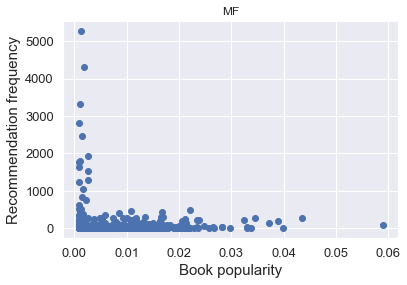

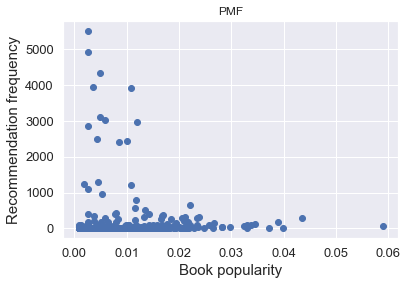

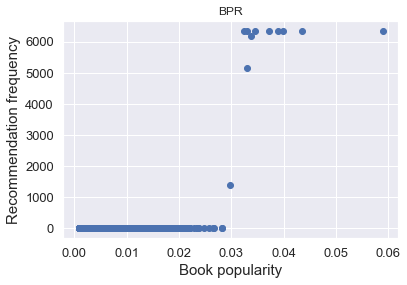

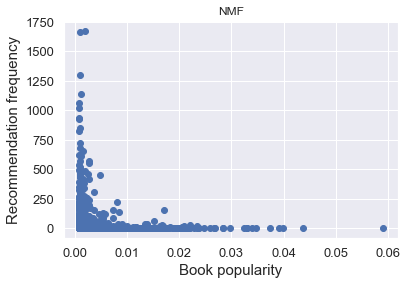

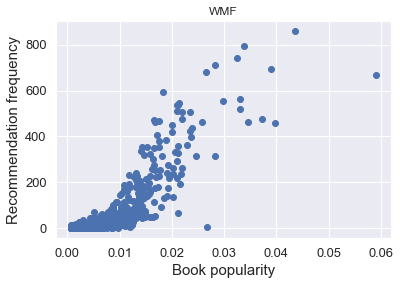

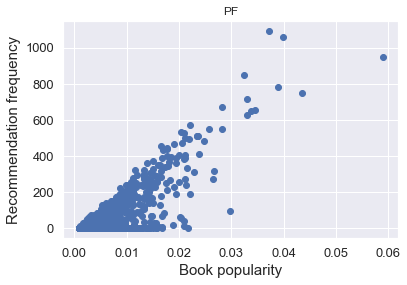

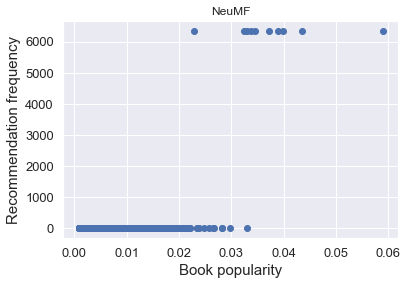

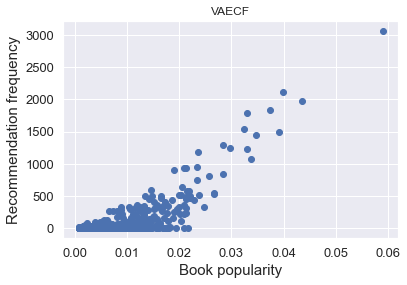

In [16]:
sns.set(rc = {'figure.figsize':(5,4)})
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist_Cornac["count"]
    y = df_item_dist_Cornac[algo_names[i]]

    plt.plot(x, y, 'o')
    plt.title(algo_names[i])
    plt.xlabel('Book popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')

### D.2. DGAP per group

In [23]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list_Cornac[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((med_rec_gap_list_Cornac[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list_Cornac[i] - high_GAP) / high_GAP * 100)

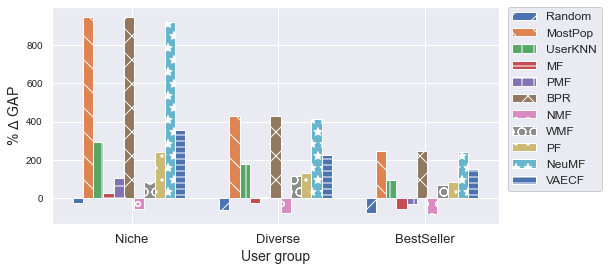

In [24]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]
bars5 = [low_gap_vals[4], medium_gap_vals[4], high_gap_vals[4]]
bars6 = [low_gap_vals[5], medium_gap_vals[5], high_gap_vals[5]]
bars7 = [low_gap_vals[6], medium_gap_vals[6], high_gap_vals[6]]
bars8 = [low_gap_vals[7], medium_gap_vals[7], high_gap_vals[7]]
bars9 = [low_gap_vals[8], medium_gap_vals[8], high_gap_vals[8]]
bars10 = [low_gap_vals[9], medium_gap_vals[9], high_gap_vals[9]]
bars11 = [low_gap_vals[10], medium_gap_vals[10], high_gap_vals[10]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
# r12 = [x + barWidth for x in r11]
# r13 = [x + barWidth for x in r12]

# ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserKNN', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='MF', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='PMF', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='BPR', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='NMF', hatch=patterns[6])
plt.bar(r8, bars8, width=barWidth, label='WMF', hatch=patterns[7])
plt.bar(r9, bars9, width=barWidth, label='PF', hatch=patterns[8])
plt.bar(r10, bars10, width=barWidth, label='NeuMF', hatch=patterns[9])
plt.bar(r11, bars11, width=barWidth, label='VAECF', hatch=patterns[10])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['Niche', 'Diverse', 'BestSeller'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()
#plt.savefig('gap_analysis.pdf', dpi=300, bbox_inches='tight')

### D3. Different user groups and metrics

In [19]:
print("User groups evaluation is started ...")

niche_users = list()
divers_users = list()
focused_users = list()

metric_group_results = defaultdict(list)
metric_group_results['MAE'] = list()
metric_group_results['Precision@10'] = list()
metric_group_results['Recall@10'] = list()
metric_group_results['NDCG@10'] = list()

ttest_group_results = defaultdict(list)
ttest_group_results['MAE'] = list()
ttest_group_results['Precision@10'] = list()
ttest_group_results['Recall@10'] = list()
ttest_group_results['NDCG@10'] = list()

for eachresult in exp_results:
    print("> " + eachresult.model_name)
    user_results = eachresult.metric_user_results # <- this is a dictionary
    for metric in exp_metrics:
        for user_idx, user_performance in user_results[metric.name].items():
            user_id = int(training_ids[user_idx])
            if user_id in low_users.index:
                niche_users.append(user_performance)
            elif user_id in med_users.index:
                divers_users.append(user_performance)
            elif user_id in high_users.index:
                focused_users.append(user_performance)
            else:
                print("Oops! We could not find a user!")

        print(metric.name + ": " + str(round(np.mean(niche_users), 4)) + "," + str(round(np.mean(divers_users), 4)) + "," + str(round(np.mean(focused_users), 4)))
        if metric.name in metric_group_results.keys():
            metric_group_results[metric.name].append((round(np.mean(niche_users), 4),
                                                round(np.mean(divers_users), 4),
                                                round(np.mean(focused_users), 4)))
      
            ttest_group_results[metric.name].append((round(stats.ttest_ind(niche_users, divers_users)[1], 8),
                                               round(stats.ttest_ind(niche_users, focused_users)[1], 8),
                                              round(stats.ttest_ind(divers_users, focused_users)[1], 8)))

        print(stats.ttest_ind(niche_users, focused_users))
        print(len(niche_users)+len(divers_users)+len(focused_users))
        niche_users.clear()
        divers_users.clear()
        focused_users.clear()
    print()

User groups evaluation is started ...
> MostPop
MAE: 2.6761,2.3935,2.1907
Ttest_indResult(statistic=7.336645503209952, pvalue=3.161165953857668e-13)
5304
MSE: 11.1997,9.1983,7.7694
Ttest_indResult(statistic=8.03487851340836, pvalue=1.5803132772449173e-15)
5304
RMSE: 2.949,2.6818,2.3725
Ttest_indResult(statistic=8.476243317500444, pvalue=4.4297399046742935e-17)
5304
AUC: 0.4906,0.7103,0.8791
Ttest_indResult(statistic=-41.793439827615344, pvalue=2.5937001889328994e-275)
5304
MAP: 0.0041,0.0154,0.0332
Ttest_indResult(statistic=-9.222870627477118, pvalue=7.082450557948636e-20)
5304
MRR: 0.0092,0.0407,0.0639
Ttest_indResult(statistic=-9.145537616746358, pvalue=1.4113942576706462e-19)
5304
Precision@5: 0.0014,0.0106,0.0154
Ttest_indResult(statistic=-7.714814366310843, pvalue=1.89323013096052e-14)
5304
Precision@10: 0.0018,0.0097,0.0137
Ttest_indResult(statistic=-9.379411800091624, pvalue=1.7261552575613993e-20)
5304
Precision@20: 0.0018,0.0081,0.0109
Ttest_indResult(statistic=-10.99956076008

NDCG@50: 0.0066,0.0118,0.0183
Ttest_indResult(statistic=-4.815450988297629, pvalue=1.578286541482736e-06)
5304
F1@5: 0.0019,0.0021,0.0034
Ttest_indResult(statistic=-1.2780005344313181, pvalue=0.2013967324705401)
5304
F1@10: 0.0022,0.0034,0.005
Ttest_indResult(statistic=-2.512596050247485, pvalue=0.012062335905422383)
5304
F1@20: 0.0015,0.0041,0.0043
Ttest_indResult(statistic=-3.6890529543198105, pvalue=0.0002310694402989822)
5304
F1@50: 0.0018,0.0042,0.0044
Ttest_indResult(statistic=-5.110677530185013, pvalue=3.513902300920734e-07)
5304

> NMF
MAE: 2.2592,2.1924,2.1465
Ttest_indResult(statistic=2.378471134423842, pvalue=0.017477497172930637)
5304
MSE: 6.892,6.5292,6.2859
Ttest_indResult(statistic=2.389862736644077, pvalue=0.016946257550958934)
5304
RMSE: 2.3976,2.3528,2.261
Ttest_indResult(statistic=2.8462481373732422, pvalue=0.004468622261825603)
5304
AUC: 0.504,0.534,0.5593
Ttest_indResult(statistic=-5.638168031647264, pvalue=1.9613275238277594e-08)
5304
MAP: 0.0024,0.0018,0.0018
Tte

F1@20: 0.0025,0.0122,0.0175
Ttest_indResult(statistic=-11.189556389815868, pvalue=3.072020117152456e-28)
5304
F1@50: 0.0028,0.0111,0.0144
Ttest_indResult(statistic=-13.880436675875115, pvalue=6.680163350512488e-42)
5304

> VAECF
MAE: 6.7658,6.7212,6.7871
Ttest_indResult(statistic=-0.31725653264984993, pvalue=0.7510818907476828)
5304
MSE: 49.0123,48.4574,49.1057
Ttest_indResult(statistic=-0.11018244218005468, pvalue=0.9122756806434095)
5304
RMSE: 6.8366,6.8174,6.8552
Ttest_indResult(statistic=-0.28095493632380275, pvalue=0.7787738659717846)
5304
AUC: 0.735,0.8059,0.9088
Ttest_indResult(statistic=-23.550475585878658, pvalue=1.6561925517844662e-108)
5304
MAP: 0.0117,0.0244,0.0505
Ttest_indResult(statistic=-10.068961329597286, pvalue=2.673766412465105e-23)
5304
MRR: 0.0257,0.0565,0.0876
Ttest_indResult(statistic=-8.980209010442564, pvalue=6.057140123665632e-19)
5304
Precision@5: 0.0066,0.0162,0.0238
Ttest_indResult(statistic=-7.1849734938161305, pvalue=9.428126930375372e-13)
5304
Precision

In [20]:
len(low_users)*0.8

1016.0

In [21]:
6400*0.8

5120.0

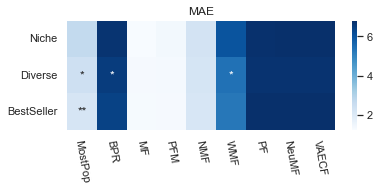

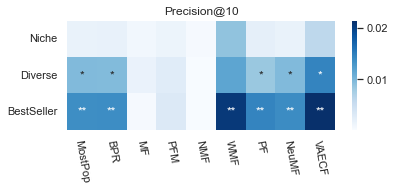

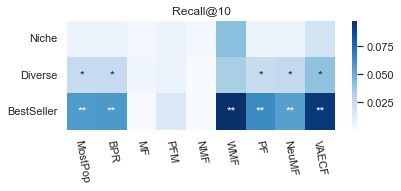

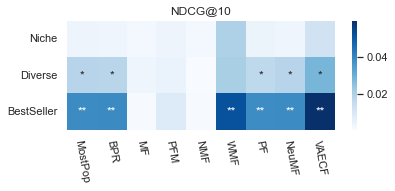

In [22]:
sns.set(rc = {'figure.figsize':(6,2)})

for metric in ['MAE', 'Precision@10', 'Recall@10', 'NDCG@10']:
    data = [[], [], []]
    labels = [['', '', '', '', '', '', '', '', ''], [], []]

    for item in metric_group_results[metric]:
        # print(item)
        data[0].append(item[0])
        data[1].append(item[1])
        data[2].append(item[2])


    for item in ttest_group_results[metric]:
        if item[0] < 0.005:
            labels[1].append('*')
        else:
            labels[1].append('')
        if item[1] < 0.005 and item[2] < 0.005:
            labels[2].append('**')
        else:
            labels[2].append('')

    fig, ax = plt.subplots()
    ax.set_title(metric)
    ax = sns.heatmap(data, annot=labels, fmt = '', cmap="Blues")
    ax.set_xticklabels(['MostPop', 'BPR', 'MF', 'PFM', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF'])
    ax.set_yticklabels(['Niche', 'Diverse', 'BestSeller'])
    ax.tick_params(axis='x', rotation=280)
    ax.tick_params(axis='y', rotation=0)
    #plt.savefig(f'{metric}_metric_analysis.pdf', dpi=300, bbox_inches='tight')